(cass_koopmans_1)=
```{raw} html
<div id="qe-notebook-header" align="right" style="text-align:right;">
        <a href="https://quantecon.org/" title="quantecon.org">
                <img style="width:250px;display:inline;" width="250px" src="https://assets.quantecon.org/img/qe-menubar-logo.svg" alt="QuantEcon">
        </a>
</div>
```

# Cass-Koopmans Model

```{contents} Contents
:depth: 2
```

## Overview

This lecture and {doc}`Cass-Koopmans Competitive Equilibrium <cass_koopmans_2>` describe a model that Tjalling Koopmans {cite}`Koopmans`
and David Cass {cite}`Cass` used to analyze optimal growth.

The model can be viewed as an extension of the model of Robert Solow
described in [an earlier lecture](https://lectures.quantecon.org/py/python_oop.html)
but adapted to make the saving rate be a choice.

(Solow assumed a constant saving rate determined outside the model.)

We describe two versions of the model, one in this lecture and the other in {doc}`Cass-Koopmans Competitive Equilibrium <cass_koopmans_2>`.

Together, the two lectures  illustrate what is, in fact, a
more general connection between a **planned economy** and a decentralized economy
organized as a **competitive equilibrium**.

This lecture is devoted to the planned economy version.

In the planned economy, there are

- no prices
- no budget constraints

Instead there is a dictator that tells people

- what to produce
- what to invest in physical capital
- who is to consume what  and when

The lecture uses important ideas including

- A min-max problem for solving a planning problem.
- A **shooting algorithm** for solving difference equations subject
  to initial and terminal conditions.
- A **turnpike** property that describes optimal paths for
  long but finite-horizon economies.

Let's start with some standard imports:

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (11, 5)  #set default figure size
from numba import njit, float64
from numba.experimental import jitclass
import numpy as np

## The Model

Time is discrete and takes values $t = 0, 1 , \ldots, T$ where $T$ is  finite.

(We'll eventually study a limiting case in which  $T = + \infty$)

A single good can either be consumed or invested in physical capital.

The consumption good is not durable and depreciates completely if not
consumed immediately.

The capital good is durable but depreciates.

We let $C_t$ be the total consumption of a nondurable  consumption good at time $t$.

Let $K_t$ be the stock of physical capital at time $t$.

Let $\vec{C}$ = $\{C_0,\dots, C_T\}$ and
$\vec{K}$ = $\{K_0,\dots,K_{T+1}\}$.

### Digression: an Aggregation Theory

We use a concept of a representative consumer to be thought of as follows.

There is a unit mass of identical consumers.

For $\omega \in [0,1]$, consumption of consumer  is $c(\omega)$.

Aggregate consumption is 

$$ 
C = \int_0^1 c(\omega) d \omega
$$

Consider the a welfare problem of choosing an allocation $\{c(\omega)\}$ across consumers to maximize

$$
 \int_0^1 u(c(\omega)) d \omega
$$ 

where $u(\cdot)$ is a concave utility function with $u' >0, u'' < 0$ and  maximization is subject to 

$$ 
C = \int_0^1 c(\omega) d \omega .
$$ (eq:feas200)

Form a Lagrangian $L = \int_0^1 u(c(\omega)) d \omega + \lambda [C - \int_0^1 c(\omega) d \omega ] $.

Differentiate under the integral signs with respect to each $\omega$ to  obtain the first-order
necessary condtions 

$$
u'(c(\omega)) = \lambda. 
$$ 

This condition implies that $c(\omega)$ equals a constant $c$ that is independent 
of $\omega$.  

To find $c$, use the  feasibility constraint {eq}`eq:feas200` to conclude that 

$$ 
c(\omega) = c = C.
$$

This line of argument indicates the special *aggregation theory* that lies beneath outcomes in which a representative consumer 
consumes amount $C$.

It appears often in aggregate economics. 

We shall use it in this lecture and in {doc}`Cass-Koopmans Competitive Equilibrium <cass_koopmans_2>`.


#### An  Economy


A representative household is endowed with one unit of labor at each
$t$ and likes the consumption good at each $t$.

The representative household inelastically supplies a single unit of
labor $N_t$ at each $t$, so that
$N_t =1 \text{ for all } t \in [0,T]$.

The representative household has preferences over consumption bundles
ordered by the utility functional:

```{math}
:label: utility-functional

U(\vec{C}) = \sum_{t=0}^{T} \beta^t \frac{C_t^{1-\gamma}}{1-\gamma}
```

where $\beta \in (0,1)$ is a discount factor and $\gamma >0$
governs the curvature of the one-period utility function with larger $\gamma$ implying more curvature.

Note that

```{math}
:label: utility-oneperiod

u(C_t) = \frac{C_t^{1-\gamma}}{1-\gamma}
```

satisfies $u'>0,u''<0$.

$u' > 0$ asserts that the consumer prefers more to less.

$u''< 0$ asserts that marginal utility declines with increases
in $C_t$.

We assume that $K_0 > 0$ is an  exogenous  initial
capital stock.

There is an economy-wide production function

```{math}
:label: production-function

F(K_t,N_t) = A K_t^{\alpha}N_t^{1-\alpha}
```

with $0 < \alpha<1$, $A > 0$.

A feasible allocation $\vec{C}, \vec{K}$ satisfies

```{math}
:label: allocation

C_t + K_{t+1} \leq F(K_t,N_t) + (1-\delta) K_t, \quad \text{for all } t \in [0, T]
```

where $\delta \in (0,1)$ is a depreciation rate of capital.

## Planning Problem

A planner chooses an allocation $\{\vec{C},\vec{K}\}$ to
maximize {eq}`utility-functional` subject to {eq}`allocation`.

Let $\vec{\mu}=\{\mu_0,\dots,\mu_T\}$ be a sequence of
nonnegative **Lagrange multipliers**.

To find an optimal allocation, form a Lagrangian

$$
\mathcal{L}(\vec{C} ,\vec{K} ,\vec{\mu} ) =
\sum_{t=0}^T \beta^t\left\{ u(C_t)+ \mu_t
\left(F(K_t,1) + (1-\delta) K_t- C_t - K_{t+1} \right)\right\}
$$ (eq:Lagrangian201)

and then pose the following min-max problem:

```{math}
:label: min-max-prob

\min_{\vec{\mu}} \max_{\vec{C},\vec{K}} \mathcal{L}(\vec{C},\vec{K},\vec{\mu} )
```

- **Extremization** means
  maximization with respect to $\vec{C}, \vec{K}$ and
  minimization with respect to $\vec{\mu}$.
- Our problem satisfies
  conditions that assure that required second-order
  conditions are satisfied at an allocation that satisfies the
  first-order conditions that we are about to compute.

Before computing first-order conditions, we present some handy formulas.

### Useful Properties of Linearly Homogeneous Production Function

The following technicalities will help us.

Notice that

$$
F(K_t,N_t) = A K_t^\alpha N_t^{1-\alpha} = N_t A\left(\frac{K_t}{N_t}\right)^\alpha
$$

Define the **output per-capita production function**

$$
\frac{F(K_t,N_t)}{N_t} \equiv f\left(\frac{K_t}{N_t}\right) = A\left(\frac{K_t}{N_t}\right)^\alpha
$$

whose argument is **capital per-capita**.

It is useful to recall the following calculations for the marginal product of capital

```{math}
:label: useful-calc1

\begin{aligned}
\frac{\partial F(K_t,N_t)}{\partial K_t}
& =
\frac{\partial N_t f\left( \frac{K_t}{N_t}\right)}{\partial K_t}
\\ &=
N_t f'\left(\frac{K_t}{N_t}\right)\frac{1}{N_t} \quad \text{(Chain rule)}
\\ &=
f'\left.\left(\frac{K_t}{N_t}\right)\right|_{N_t=1}
\\ &= f'(K_t)
\end{aligned}
```

and the marginal product of labor

$$
\begin{aligned}
\frac{\partial F(K_t,N_t)}{\partial N_t}
&=
\frac{\partial N_t f\left( \frac{K_t}{N_t}\right)}{\partial N_t} \quad \text{(Product rule)}
\\ &=
f\left(\frac{K_t}{N_t}\right){+} N_t f'\left(\frac{K_t}{N_t}\right) \frac{-K_t}{N_t^2} \quad \text{(Chain rule)}
\\ &=
f\left(\frac{K_t}{N_t}\right){-}\frac{K_t}{N_t}f'\left.\left(\frac{K_t}{N_t}\right)\right|_{N_t=1}
\\ &=
f(K_t) - f'(K_t) K_t
\end{aligned}
$$

### First-order necessary conditions

We now compute **first-order necessary conditions** for extremization of the Lagrangian {eq}`eq:Lagrangian201`:

```{math}
:label: constraint1

C_t: \qquad u'(C_t)-\mu_t=0 \qquad \text{for all} \quad t= 0,1,\dots,T
```

```{math}
:label: constraint2

K_t: \qquad \beta \mu_t\left[(1-\delta)+f'(K_t)\right] - \mu_{t-1}=0 \qquad \text{for all } \quad t=1,2,\dots,T
```

```{math}
:label: constraint3

\mu_t:\qquad F(K_t,1)+ (1-\delta) K_t  - C_t - K_{t+1}=0 \qquad \text{for all } \quad t=0,1,\dots,T
```

```{math}
:label: constraint4

K_{T+1}: \qquad -\mu_T \leq 0, \ \leq 0 \text{ if } K_{T+1}=0; \ =0 \text{ if } K_{T+1}>0
```

In computing  {eq}`constraint3` we recognize that $K_t$ appears
in both the time  $t$ and time $t-1$ feasibility constraints.

Restrictions {eq}`constraint4` come from differentiating with respect
to $K_{T+1}$ and applying the following **Karush-Kuhn-Tucker condition** (KKT)
(see [Karush-Kuhn-Tucker conditions](https://en.wikipedia.org/wiki/Karush-Kuhn-Tucker_conditions)):

```{math}
:label: kkt

\mu_T K_{T+1}=0
```

Combining {eq}`constraint1` and {eq}`constraint2` gives

$$
u'\left(C_t\right)\left[(1-\delta)+f'\left(K_t\right)\right]-u'\left(C_{t-1}\right)=0
\quad \text{ for all } t=1,2,\dots, T+1
$$

which can be rearranged to become

```{math}
:label: l12

u'\left(C_{t+1}\right)\left[(1-\delta)+f'\left(K_{t+1}\right)\right]=
u'\left(C_{t}\right) \quad \text{ for all } t=0,1,\dots, T
```

Applying  the inverse of the utility function on both sides of the above
equation gives

$$
C_{t+1} =u'^{-1}\left(\left(\frac{\beta}{u'(C_t)}[f'(K_{t+1}) +(1-\delta)]\right)^{-1}\right)
$$

which for our utility function {eq}`utility-oneperiod` becomes the consumption **Euler
equation**

$$
\begin{aligned} C_{t+1} =\left(\beta C_t^{\gamma}[f'(K_{t+1}) +
(1-\delta)]\right)^{1/\gamma} \notag\\= C_t\left(\beta [f'(K_{t+1}) +
(1-\delta)]\right)^{1/\gamma} \end{aligned}
$$

Below we define a `jitclass` that stores parameters and functions
that define our economy.

In [2]:
planning_data = [
    ('γ', float64),    # Coefficient of relative risk aversion
    ('β', float64),    # Discount factor
    ('δ', float64),    # Depreciation rate on capital
    ('α', float64),    # Return to capital per capita
    ('A', float64)     # Technology
]

In [3]:
@jitclass(planning_data)
class PlanningProblem():

    def __init__(self, γ=2, β=0.95, δ=0.02, α=0.33, A=1):

        self.γ, self.β = γ, β
        self.δ, self.α, self.A = δ, α, A

    def u(self, c):
        '''
        Utility function
        ASIDE: If you have a utility function that is hard to solve by hand
        you can use automatic or symbolic differentiation
        See https://github.com/HIPS/autograd
        '''
        γ = self.γ

        return c ** (1 - γ) / (1 - γ) if γ!= 1 else np.log(c)

    def u_prime(self, c):
        'Derivative of utility'
        γ = self.γ

        return c ** (-γ)

    def u_prime_inv(self, c):
        'Inverse of derivative of utility'
        γ = self.γ

        return c ** (-1 / γ)

    def f(self, k):
        'Production function'
        α, A = self.α, self.A

        return A * k ** α

    def f_prime(self, k):
        'Derivative of production function'
        α, A = self.α, self.A

        return α * A * k ** (α - 1)

    def f_prime_inv(self, k):
        'Inverse of derivative of production function'
        α, A = self.α, self.A

        return (k / (A * α)) ** (1 / (α - 1))

    def next_k_c(self, k, c):
        ''''
        Given the current capital Kt and an arbitrary feasible
        consumption choice Ct, computes Kt+1 by state transition law
        and optimal Ct+1 by Euler equation.
        '''
        β, δ = self.β, self.δ
        u_prime, u_prime_inv = self.u_prime, self.u_prime_inv
        f, f_prime = self.f, self.f_prime

        k_next = f(k) + (1 - δ) * k - c
        c_next = u_prime_inv(u_prime(c) / (β * (f_prime(k_next) + (1 - δ))))

        return k_next, c_next

We can construct an economy with the Python code:

In [4]:
pp = PlanningProblem()

## Shooting Algorithm

We use  **shooting** to compute an optimal allocation
$\vec{C}, \vec{K}$ and an associated Lagrange multiplier sequence
$\vec{\mu}$.

The first-order necessary conditions
{eq}`constraint1`, {eq}`constraint2`, and
{eq}`constraint3`  for the planning problem form a system of **difference equations** with
two boundary conditions:

- $K_0$ is a given **initial condition** for capital
- $K_{T+1} =0$ is a **terminal condition** for capital that we
  deduced from the first-order necessary condition for $K_{T+1}$
  the KKT condition {eq}`kkt`

We have no initial condition for the Lagrange multiplier
$\mu_0$.

If we did, our job would be easy:

- Given $\mu_0$ and $k_0$, we could compute $c_0$ from
  equation {eq}`constraint1` and then $k_1$ from equation
  {eq}`constraint3` and $\mu_1$ from equation
  {eq}`constraint2`.
- We could continue in this way to compute the remaining elements of
  $\vec{C}, \vec{K}, \vec{\mu}$.

But we don't have an initial condition for $\mu_0$, so this
won't work.

Indeed, part of our task is to compute the optimal value of $\mu_0$.

To compute $\mu_0$ and the other objects we want, a  simple modification of the above procedure will work.

It is  called the **shooting algorithm**.

It is  an instance of a **guess and verify**
algorithm that consists of the following steps:

- Guess an initial Lagrange multiplier $\mu_0$.
- Apply the **simple algorithm** described above.
- Compute $k_{T+1}$ and check whether it
  equals zero.
- If  $K_{T+1} =0$, we have solved the problem.
- If $K_{T+1} > 0$, lower $\mu_0$ and try again.
- If $K_{T+1} < 0$, raise $\mu_0$ and try again.

The following Python code implements the shooting algorithm for the
planning problem.

We actually modify the algorithm slightly by starting with a guess for
$c_0$ instead of $\mu_0$ in the following code.

In [5]:
@njit
def shooting(pp, c0, k0, T=10):
    '''
    Given the initial condition of capital k0 and an initial guess
    of consumption c0, computes the whole paths of c and k
    using the state transition law and Euler equation for T periods.
    '''
    if c0 > pp.f(k0):
        print("initial consumption is not feasible")

        return None

    # initialize vectors of c and k
    c_vec = np.empty(T+1)
    k_vec = np.empty(T+2)

    c_vec[0] = c0
    k_vec[0] = k0

    for t in range(T):
        k_vec[t+1], c_vec[t+1] = pp.next_k_c(k_vec[t], c_vec[t])

    k_vec[T+1] = pp.f(k_vec[T]) + (1 - pp.δ) * k_vec[T] - c_vec[T]

    return c_vec, k_vec

We’ll start with an incorrect guess.

In [6]:
paths = shooting(pp, 0.2, 0.3, T=10)

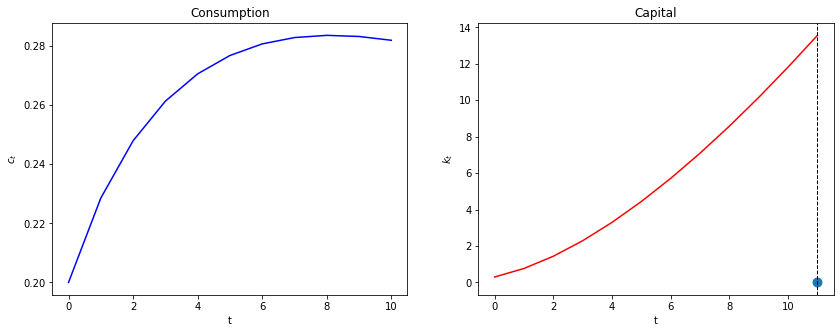

In [7]:
fig, axs = plt.subplots(1, 2, figsize=(14, 5))

colors = ['blue', 'red']
titles = ['Consumption', 'Capital']
ylabels = ['$c_t$', '$k_t$']

T = paths[0].size - 1
for i in range(2):
    axs[i].plot(paths[i], c=colors[i])
    axs[i].set(xlabel='t', ylabel=ylabels[i], title=titles[i])

axs[1].scatter(T+1, 0, s=80)
axs[1].axvline(T+1, color='k', ls='--', lw=1)

plt.show()

Evidently, our initial guess for $\mu_0$ is too high, so
initial consumption too low.

We know this because we miss our $K_{T+1}=0$ target on the high
side.

Now we automate things with a search-for-a-good $\mu_0$
algorithm that stops when we hit the target $K_{t+1} = 0$.

We use a **bisection method**.

We make an initial guess for $C_0$ (we can eliminate
$\mu_0$ because $C_0$ is an exact function of
$\mu_0$).

We know that the lowest $C_0$ can ever be is $0$ and the
largest it can be is initial output $f(K_0)$.

Guess $C_0$  and shoot forward to $T+1$.

If $K_{T+1}>0$, we take it to be our new **lower** bound
on $C_0$.

If $K_{T+1}<0$, we take  it to be our new **upper** bound.

Make a new guess for $C_0$ that is  halfway between our new
upper and lower bounds.

Shoot forward again, iterating on these steps until we converge.

When $K_{T+1}$ gets close enough to $0$ (i.e., within an error
tolerance bounds), we stop.

In [8]:
@njit
def bisection(pp, c0, k0, T=10, tol=1e-4, max_iter=500, k_ter=0, verbose=True):

    # initial boundaries for guess c0
    c0_upper = pp.f(k0)
    c0_lower = 0

    i = 0
    while True:
        c_vec, k_vec = shooting(pp, c0, k0, T)
        error = k_vec[-1] - k_ter

        # check if the terminal condition is satisfied
        if np.abs(error) < tol:
            if verbose:
                print('Converged successfully on iteration ', i+1)
            return c_vec, k_vec

        i += 1
        if i == max_iter:
            if verbose:
                print('Convergence failed.')
            return c_vec, k_vec

        # if iteration continues, updates boundaries and guess of c0
        if error > 0:
            c0_lower = c0
        else:
            c0_upper = c0

        c0 = (c0_lower + c0_upper) / 2

In [9]:
def plot_paths(pp, c0, k0, T_arr, k_ter=0, k_ss=None, axs=None):

    if axs is None:
        fix, axs = plt.subplots(1, 3, figsize=(16, 4))
    ylabels = ['$c_t$', '$k_t$', '$\mu_t$']
    titles = ['Consumption', 'Capital', 'Lagrange Multiplier']

    c_paths = []
    k_paths = []
    for T in T_arr:
        c_vec, k_vec = bisection(pp, c0, k0, T, k_ter=k_ter, verbose=False)
        c_paths.append(c_vec)
        k_paths.append(k_vec)

        μ_vec = pp.u_prime(c_vec)
        paths = [c_vec, k_vec, μ_vec]

        for i in range(3):
            axs[i].plot(paths[i])
            axs[i].set(xlabel='t', ylabel=ylabels[i], title=titles[i])

        # Plot steady state value of capital
        if k_ss is not None:
            axs[1].axhline(k_ss, c='k', ls='--', lw=1)

        axs[1].axvline(T+1, c='k', ls='--', lw=1)
        axs[1].scatter(T+1, paths[1][-1], s=80)

    return c_paths, k_paths

Now we can solve the model and plot the paths of consumption, capital, and Lagrange multiplier.

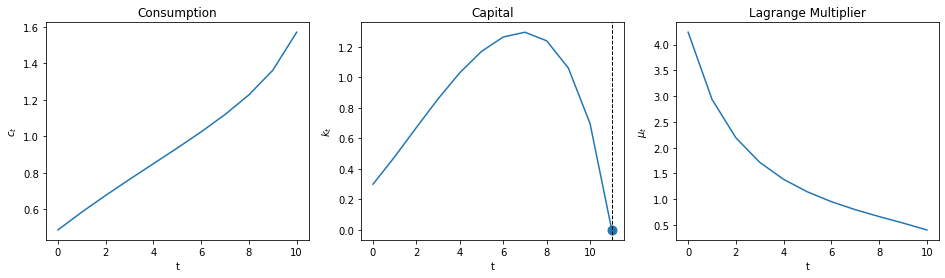

In [10]:
plot_paths(pp, 0.3, 0.3, [10]);

## Setting Initial Capital to Steady State Capital

When  $T \rightarrow +\infty$, the optimal allocation converges to
steady state values of $C_t$ and $K_t$.

It is instructive to set $K_0$ equal
to the $\lim_{T \rightarrow + \infty } K_t$, which we'll call  steady state capital.

In a steady state $K_{t+1} = K_t=\bar{K}$ for all very
large $t$.

Evalauating the feasibility constraint {eq}`allocation` at $\bar K$ gives

```{math}
:label: feasibility-constraint

f(\bar{K})-\delta \bar{K} = \bar{C}
```

Substituting $K_t = \bar K$ and $C_t=\bar C$ for
all $t$ into {eq}`l12` gives

$$
1=\beta \frac{u'(\bar{C})}{u'(\bar{C})}[f'(\bar{K})+(1-\delta)]
$$

Defining $\beta = \frac{1}{1+\rho}$, and cancelling gives

$$
1+\rho = 1[f'(\bar{K}) + (1-\delta)]
$$

Simplifying gives

$$
f'(\bar{K}) = \rho +\delta
$$

and

$$
\bar{K} = f'^{-1}(\rho+\delta)
$$

For the  production function {eq}`production-function` this becomes

$$
\alpha \bar{K}^{\alpha-1} = \rho + \delta
$$

As an example, after setting $\alpha= .33$,
$\rho = 1/\beta-1 =1/(19/20)-1 = 20/19-19/19 = 1/19$, $\delta = 1/50$,
we get

$$
\bar{K} = \left(\frac{\frac{33}{100}}{\frac{1}{50}+\frac{1}{19}}\right)^{\frac{67}{100}} \approx 9.57583
$$

Let's verify this with Python and then use this steady state
$\bar K$ as our initial capital stock $K_0$.

In [11]:
ρ = 1 / pp.β - 1
k_ss = pp.f_prime_inv(ρ+pp.δ)

print(f'steady state for capital is: {k_ss}')

steady state for capital is: 9.57583816331462


Now we plot

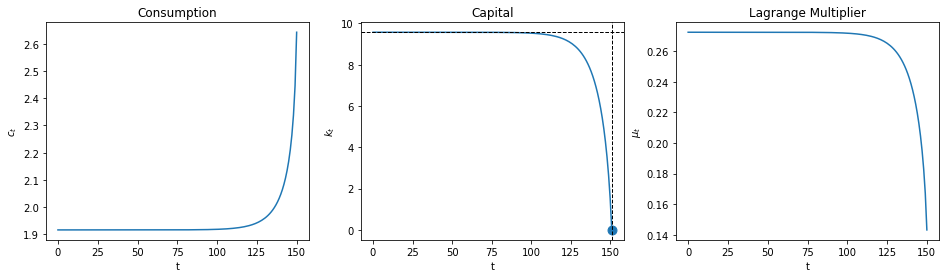

In [12]:
plot_paths(pp, 0.3, k_ss, [150], k_ss=k_ss);

Evidently,  with a large value of
$T$, $K_t$ stays near $K_0$ until $t$ approaches $T$ closely.

Let's see what the planner does when we set
$K_0$ below $\bar K$.

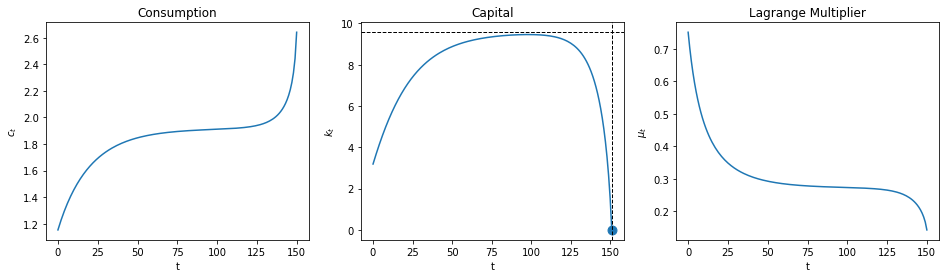

In [13]:
plot_paths(pp, 0.3, k_ss/3, [150], k_ss=k_ss);

Notice how the planner pushes capital toward the steady state, stays
near there for a while, then pushes $K_t$ toward the terminal
value $K_{T+1} =0$ when $t$ closely approaches $T$.

The following graphs compare optimal outcomes as we vary $T$.

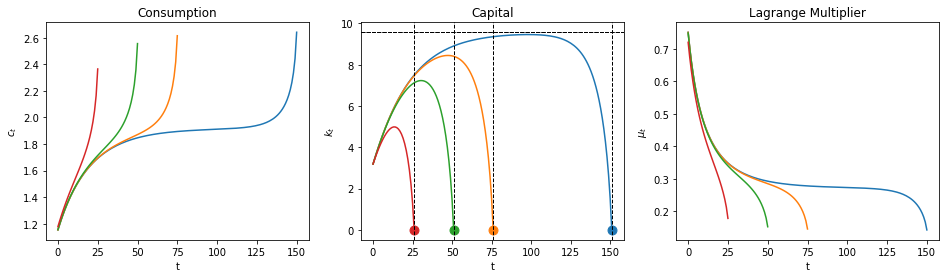

In [14]:
plot_paths(pp, 0.3, k_ss/3, [150, 75, 50, 25], k_ss=k_ss);

## A Turnpike Property

The following calculation indicates that when  $T$ is very large,
the optimal capital stock stays close to
its steady state value most of the time.

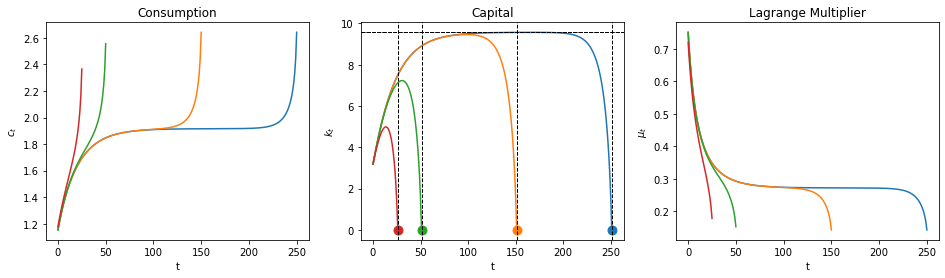

In [15]:
plot_paths(pp, 0.3, k_ss/3, [250, 150, 50, 25], k_ss=k_ss);

Different colors in the above graphs are associated with
different horizons $T$.

Notice that as the horizon increases, the planner puts $K_t$
closer to the steady state value $\bar K$ for longer.

This pattern reflects a **turnpike** property of the steady state.

A rule of thumb for the planner is

- from $K_0$, push $K_t$ toward
  the steady state and stay close to the steady state until time approaches $T$.

The planner accomplishes this by adjusting the saving rate $\frac{f(K_t) - C_t}{f(K_t)}$
over time.

Let's calculate and  plot the saving rate.

In [16]:
@njit
def saving_rate(pp, c_path, k_path):
    'Given paths of c and k, computes the path of saving rate.'
    production = pp.f(k_path[:-1])

    return (production - c_path) / production

In [17]:
def plot_saving_rate(pp, c0, k0, T_arr, k_ter=0, k_ss=None, s_ss=None):

    fix, axs = plt.subplots(2, 2, figsize=(12, 9))

    c_paths, k_paths = plot_paths(pp, c0, k0, T_arr, k_ter=k_ter, k_ss=k_ss, axs=axs.flatten())

    for i, T in enumerate(T_arr):
        s_path = saving_rate(pp, c_paths[i], k_paths[i])
        axs[1, 1].plot(s_path)

    axs[1, 1].set(xlabel='t', ylabel='$s_t$', title='Saving rate')

    if s_ss is not None:
        axs[1, 1].hlines(s_ss, 0, np.max(T_arr), linestyle='--')

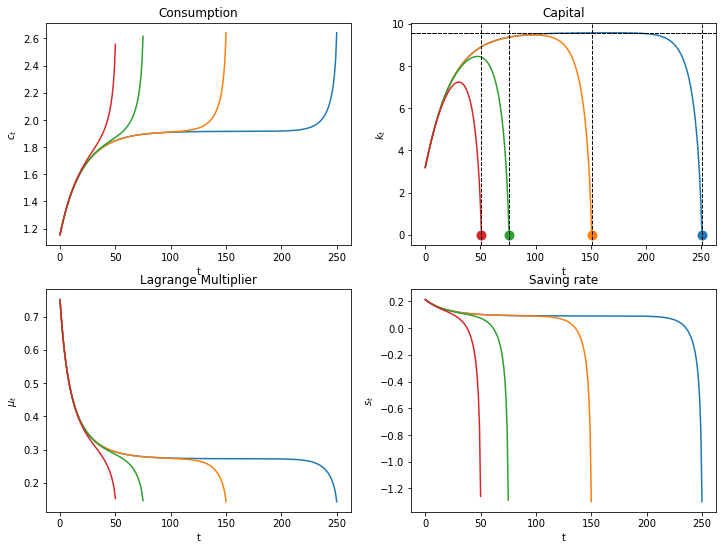

In [18]:
plot_saving_rate(pp, 0.3, k_ss/3, [250, 150, 75, 50], k_ss=k_ss)

## A Limiting Infinite Horizon Economy

We want to set $T = +\infty$.

The appropriate thing to do is to replace terminal condition
{eq}`constraint4` with

$$
\lim_{T \rightarrow +\infty} \beta^T u'(C_T) K_{T+1} = 0 ,
$$

a condition that will be satisfied by a path that converges to an
optimal steady state.

We can approximate the optimal path by starting from an arbitrary initial
$K_0$ and shooting towards the optimal steady state
$K$ at a large but finite $T+1$.

In the following code, we do this for a large $T$ and plot consumption, capital, and the
saving rate.

We know that in the steady state that the saving rate is constant
and that $\bar s= \frac{f(\bar K)-\bar C}{f(\bar K)}$.

From {eq}`feasibility-constraint` the steady state saving rate equals

$$
\bar s =\frac{ \delta \bar{K}}{f(\bar K)}
$$

The steady state saving rate $\bar S = \bar s f(\bar K)$ is
the amount required to offset capital depreciation each period.

We first study optimal capital paths that start below the steady
state.

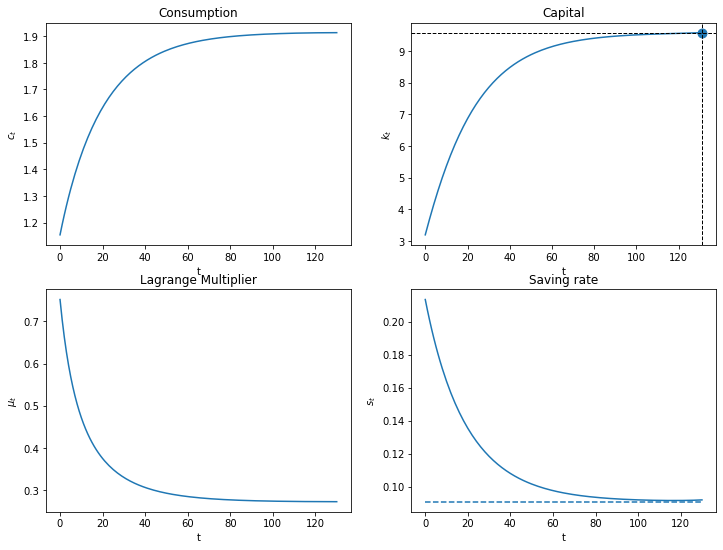

In [19]:
# steady state of saving rate
s_ss = pp.δ * k_ss / pp.f(k_ss)

plot_saving_rate(pp, 0.3, k_ss/3, [130], k_ter=k_ss, k_ss=k_ss, s_ss=s_ss)

Since $K_0<\bar K$, $f'(K_0)>\rho +\delta$.

The planner chooses a positive saving rate that is higher than  the steady state
saving rate.

Note, $f''(K)<0$, so as $K$ rises, $f'(K)$ declines.

The planner slowly lowers the saving rate until reaching a steady
state in which $f'(K)=\rho +\delta$.

### Exercise

```{exercise}
:label: ck1_ex1

- Plot the optimal consumption, capital, and saving paths when the
  initial capital level begins at 1.5 times the steady state level
  as we shoot towards the steady state at $T=130$.
- Why does the saving rate respond as it does?
```

### Solution

```{solution-start} ck1_ex1
:class: dropdown
```

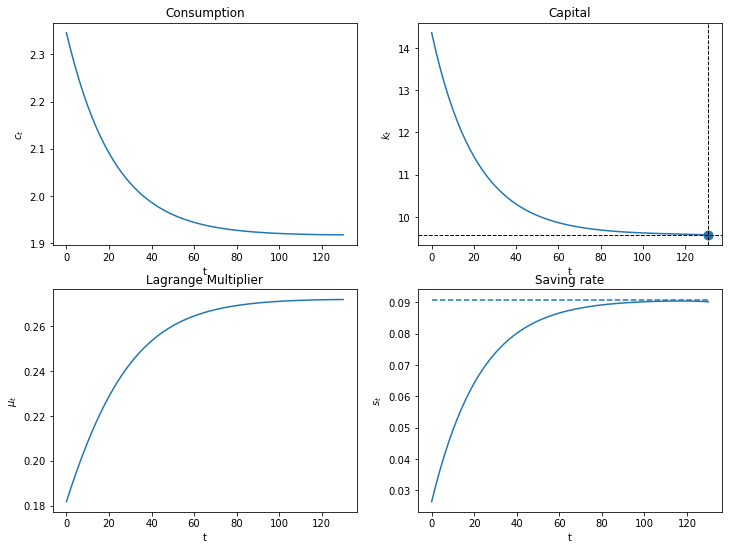

In [20]:
plot_saving_rate(pp, 0.3, k_ss*1.5, [130], k_ter=k_ss, k_ss=k_ss, s_ss=s_ss)

```{solution-end}
```

## Concluding Remarks

In {doc}`Cass-Koopmans Competitive Equilibrium <cass_koopmans_2>`,  we study a decentralized version of an economy with exactly the same
technology and preference structure as deployed here.

In that lecture, we replace the  planner of this lecture with Adam Smith's **invisible hand**.

In place of quantity choices made by the planner, there are market prices that are set by a mechanism outside the model, a so-called invisible hand.

Equilibrium market prices must reconcile distinct decisions that are made independently
by a representative household and a representative firm.

The relationship between a command economy like the one studied in this lecture and a market economy like that
studied in {doc}`Cass-Koopmans Competitive Equilibrium <cass_koopmans_2>` is a foundational topic in general equilibrium theory and welfare economics.